# Sentiment Analysis - Wildfires

## Install Libraries

In [167]:
import pandas as pd
import numpy as np
import datetime
import tweepy
import re
import spacy
import glob
import gensim
import gensim.corpora as corpora
import spacy
import nltk
import pyLDAvis
import pyLDAvis.gensim_models
import string
from nltk.stem.wordnet import WordNetLemmatizer
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from textblob import TextBlob
import datetime
from datetime import datetime

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from cleantext import clean

import wordcloud
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [77]:
from itertools import chain

In [78]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /Users/su/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /Users/su/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/su/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/su/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/su/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /Users/su/nltk_data..

True

# API

In [4]:
# Authentication
api_key = "Please insert your key"
api_key_secret = "Please insert your key"
access_key = "Please insert your key"
access_key_secret = "Please insert your key"

auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_key, access_key_secret)

api = tweepy.API(auth, wait_on_rate_limit = True)

/Users/su/Library/Python/3.8/lib/python/site-packages/tweepy/auth.py:120: DeprecationWarning: OAuthHandler is deprecated; use OAuth1UserHandler instead.
  warnings.warn(


# Gathering the Data

In [11]:
tweets = tweepy.Cursor(api.search_tweets, q = "wildfire -filter:retweets", lang = "en").items(15000)

In [12]:
%%time
tweet_list = []
tweet_date = []
tweet_rt = []
tweet_fav = []

for tweet in tweets:
    tweet_list.append(tweet.text)
    tweet_date.append(tweet.created_at)
    tweet_rt.append(tweet.retweet_count)
    tweet_fav.append(tweet.favorite_count)
    
wildfire = pd.DataFrame({"tweets": tweet_list, "date": tweet_date, "rt": tweet_rt, "fav": tweet_fav})

Unauthorized: 401 Unauthorized
89 - Invalid or expired token.

In [ ]:
wildfire.to_csv("wildfire.csv")

NameError: name 'wildfire' is not defined

# Data

In [44]:
wildfire = pd.read_csv("wildfire.csv")
wildfire.reset_index(drop=True, inplace=True)
wildfire=wildfire.dropna()

# Data Preprocessing

In [45]:
def remove_text (tweet):
    tweet = re.sub('@[A-Za-z0-9-_]+', '', tweet) #to remove mentions
    tweet = re.sub(r'#', '', tweet) # to remove hashtags
    tweet = re.sub(r'RT[/s]+', '', tweet) # to remove retweets
    return tweet

In [46]:
def remove_links (tweet):
    tweet = re.sub(r'https?:\/\/\S+', '', tweet)# remove hyper links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # remove bitly links
    tweet = tweet.strip('[links]') # remove links
    return tweet

In [47]:
mywords = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
mystopwords = set(stopwords.words('english'))
mycharacters = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•∑€®₺¥π¨`æ´¬¨∆^∂ßæ≈√∫~µ≤≥÷ƒ@'


In [48]:
def remove_words (tweet):
     tweet = re.sub('['+mycharacters + ']+', ' ', tweet) # remove characters 
     tweet = re.sub('\s+', ' ', tweet)   #remove double spacing
     tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
     return tweet

<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
/var/folders/lc/vc91d12j7x7csxcqvv3pnhqc0000gn/T/ipykernel_95506/2643602873.py:3: DeprecationWarning: invalid escape sequence \s
  tweet = re.sub('\s+', ' ', tweet)   #remove double spacing


In [49]:
def clean_tweets(tweet, bigrams=False):
    tweet = tweet.lower() # to make lower case
    tweet = remove_text(tweet)
    tweet = remove_links(tweet)
    tweet = remove_words(tweet)
    tweet = clean(tweet, no_emoji=True)
    tweet_token = [word for word in tweet.split(' ')
                            if word not in mystopwords] # remove stopwords

    tweet_token = [mywords(word) if '#' not in word else word
                        for word in tweet_token] # apply word rooter
    if bigrams:
        tweet_token = tweet_token+[tweet_token[i]+'_'+tweet_token[i+1]
                                            for i in range(len(tweet_token)-1)]
    tweet = ' '.join(tweet_token)
    tweet = re.sub('wildfir', 'wildfire', tweet) #to correct wildfire because of data cleaning
    return tweet

In [50]:
wildfire['clean_tweets'] = wildfire.tweets.apply(clean_tweets)

/Users/su/Library/Python/3.8/lib/python/site-packages/cleantext/clean.py:58: DeprecationWarning: invalid escape sequence '\ '
  text = text.encode("latin", "backslashreplace").decode("unicode-escape")
/Users/su/Library/Python/3.8/lib/python/site-packages/cleantext/clean.py:58: DeprecationWarning: invalid escape sequence '\ '
  text = text.encode("latin", "backslashreplace").decode("unicode-escape")
/Users/su/Library/Python/3.8/lib/python/site-packages/cleantext/clean.py:58: DeprecationWarning: invalid escape sequence '\ '
  text = text.encode("latin", "backslashreplace").decode("unicode-escape")


In [51]:
wildfire

,Unnamed: 0.1,Unnamed: 0,tweets,date,rt,fav,clean_tweets
0,0,0,Blue Mountains Wildfire January 1994 https://t...,14/08/2022 14:12,0,0.0,blue mountain wildfire januari
1,1,1,*Flashback*\n\nAugust 2017... wildfire Smoke b...,14/08/2022 14:10,0,0.0,flashback august wildfire smoke block sun midd...
2,2,2,@Ebuka243 just like a wildfire🦍,14/08/2022 14:10,0,0.0,like wildfire
3,3,3,Europe's blistering summer may not be over yet...,14/08/2022 14:10,0,0.0,europ blister summer may yet alreadi break rec...
4,4,4,Pretty serious #wildfire at Newgale right now ...,14/08/2022 14:09,1,1.0,pretti seriou wildfire newgal right pembrokesh...
...,...,...,...,...,...,...,...
15011,14995,14995,@Joe71545644 They are able to go out immediate...,07/08/2022 08:33,0,0.0,"abl go immedi say media ""russia target civilia..."
15012,14996,14996,devastating in particular for the Karuk and Yu...,07/08/2022 08:32,2,1.0,devast particular karuk yurok tribe tri protec...
15013,14997,14997,Now playing on WGMU: 1999 WILDFIRE (CLEAN) by ...,07/08/2022 08:28,0,0.0,ow play wgmu wildfire clean brockhampton best ...
15014,14998,14998,Want your life reduced to this bag due to wild...,07/08/2022 08:12,6,6.0,want life reduc bag due wildfire flood would r...


# Word Cloud

In [52]:
from wordcloud import WordCloud

In [53]:
text = " ".join(i for i in wildfire["clean_tweets"])
text

'blue mountain wildfire januari flashback august wildfire smoke block sun midday hol portug like wildfire europ blister summer may yet alreadi break record nearli hectar r pretti seriou wildfire newgal right pembrokeshir wale wildfire stormhour thephotohour major wildfire spain forc evacu wildflow wildfire fire spread inland due onshor breez toward hous newgal newgalebeach jame still wear flower europ set record wildfire destruct beauti bottom larg wildfire experienc colorado across west threaten home risk "the overlap wildfire risk poverti concentr insur market get peopl think polici larg wildfire northeast spain grew rapidli overnight burn control sunday forc evacu larg wildfire northeast spain grew rapidli overnight burn control sunday forc evacu campfir close weekend pack soak water dirt stir stick macron plan hold talk france\' wildfire manag jenni che aug listen articl macron plan hold talk france\' wildfire manag jenni che aug listen articl case commerci log wildfire prone fores

In [14]:
text = text.replace('amp','')
text = text.replace('ew', '')
text = text.replace('via', '')
text = text.replace('lis', '')
text = text.replace('peopl', 'people')
text = text.replace('peoplee', 'people')
text = text.replace('peopleee', 'people')
text = text.replace('peopleeee', 'people')
text = text.replace('peopleeeee', 'people')
text = text.replace('peopleeeeee', 'people')
text = text.replace('peopleeeeeee', 'people')
text = text.replace('franc', 'france')
text = text.replace('battl', 'battle')
text = text.replace('servic', 'service')
text = text.replace('wildfire near', 'near')
text = text.replace('wildfire burn', 'burn')
text = text.replace('wildfire risk', 'risk')
text = text.replace('wildfire smoke', 'smoke')
text = text.replace('wildfire season', 'season')
text = text.replace('battlee', 'battle')
text = text.replace('battlee monster', 'battle monster')
text = text.replace('francee', 'france')
text = text.replace('franceeeeeeeee', 'france')
text = text.replace('firefighterer', 'firefighter')
text = text.replace('monster wildfire', 'monster')
text = text.replace('firefighter battlee', 'firefighter battle')
text = text.replace('francee firefighter', 'firefighter')
text = text.replace('firefighterererer battlee', 'firefightererer battle')
text = text.replace('firefighterererererererererer', 'firefighter')
text = text.replace('firefighter battleeeeee', 'battle')
text = text.replace('firefighter battleeee', 'battle')
text = text.replace('firefighter battleee', 'battle')
text = text.replace('firefighter battlee', 'battle')

/Users/su/Library/Python/3.8/lib/python/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/su/Library/Python/3.8/lib/python/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/su/Library/Python/3.8/lib/python/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/su/Library/Python/3.8/lib/python/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

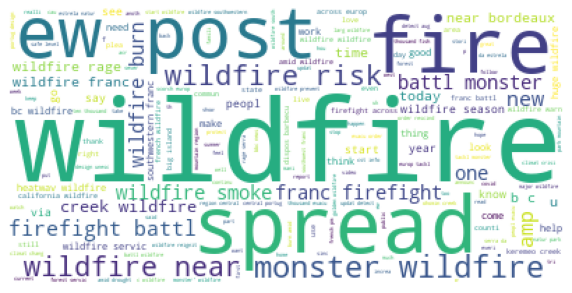

In [54]:
wordcloud = WordCloud(max_font_size = 100,
                      background_color = "white").generate(text)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# nGram

#### We wanted to see most frequent words group in order to understand the tweets more.

In [55]:
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [56]:
#n2_bigram
n2_bigrams = get_top_n_gram(wildfire['clean_tweets'],(2,2),20)
n2_bigrams

[('like wildfire', 978),
 ('spread like', 669),
 ('monster wildfire', 625),
 ('ew post', 606),
 ('wildfire risk', 447),
 ('wildfire near', 443),
 ('battl monster', 381),
 ('firefight battl', 378),
 ('wildfire smoke', 342),
 ('wildfire burn', 313),
 ('creek wildfire', 304),
 ('near bordeaux', 271),
 ('wildfire rage', 244),
 ('franc firefight', 214),
 ('wildfire season', 212),
 ('wildfire franc', 188),
 ('heatwav wildfire', 168),
 ('wildfire servic', 157),
 ('bc wildfire', 156),
 ('southwestern franc', 146)]

In [57]:
#n3_trigram
n3_trigrams = get_top_n_gram(wildfire['clean_tweets'],(3,3),20)
n3_trigrams

[('spread like wildfire', 617),
 ('battl monster wildfire', 364),
 ('monster wildfire near', 260),
 ('wildfire near bordeaux', 257),
 ('firefight battl monster', 236),
 ('franc firefight battl', 199),
 ('bc wildfire servic', 131),
 ('hawaii big island', 125),
 ('keremeo creek wildfire', 125),
 ('monster wildfire franc', 123),
 ('franc battl monster', 119),
 ('tackl monster wildfire', 109),
 ('wildfire southwestern franc', 109),
 ('firefight europ tackl', 90),
 ('europ tackl monster', 90),
 ('updat detect aug', 87),
 ('evacu order rescind', 83),
 ('french wildfire reignit', 82),
 ('serra da estrela', 82),
 ('estrela natur park', 80)]

In [58]:
wildfire[wildfire.clean_tweets.str.find('spread like wildfire')!= -1].sort_values('fav', ascending = False)

,Unnamed: 0.1,Unnamed: 0,tweets,date,rt,fav,clean_tweets
2266,2263,2263,Disinformation claiming “Trump was going to se...,13/08/2022 02:29,45,729.0,"disinform claim ""trump go sell nuclear secret ..."
9428,9422,9422,This video is spreading like wildfire on Ukrai...,10/08/2022 13:44,39,497.0,video spread like wildfire ukrainian social me...
2448,2445,2445,"We’re all going to jail! \n\nThat, and other o...",12/08/2022 23:22,86,355.0,we'r go jail overreact spread like wildfire in...
2054,2051,2051,Go audition now. Once in a lifetime opportunit...,13/08/2022 06:39,202,260.0,go audit lifetim opportun spread like wildfire
13969,13956,13956,The rumour spreads like wildfire and some snar...,08/08/2022 01:37,0,241.0,rumour spread like wildfire snarki remark made...
...,...,...,...,...,...,...,...
7230,7224,7224,That fuckin feminist is a scam video spreading...,11/08/2022 10:51,0,0.0,fuckin feminist scam video spread like wildfire
7091,7085,7085,So are we not shutting the country down with m...,11/08/2022 11:50,0,0.0,shut countri monkeypox spread like wildfire
7049,7043,7043,@Sebastijanpius @CawrCatti Turn off the Boss m...,11/08/2022 12:06,0,0.0,turn boss music need know new std spread like ...
6850,6844,6844,That shit was spread like wildfire https://t.c...,11/08/2022 13:21,0,0.0,shit spread like wildfire


In [59]:
#n4_quadgram
n4_quadgrams = get_top_n_gram(wildfire['clean_tweets'],(4,4),20)
n4_quadgrams

[('monster wildfire near bordeaux', 244),
 ('battl monster wildfire near', 236),
 ('firefight battl monster wildfire', 229),
 ('franc firefight battl monster', 194),
 ('franc battl monster wildfire', 118),
 ('firefight europ tackl monster', 90),
 ('europ tackl monster wildfire', 90),
 ('tackl monster wildfire franc', 90),
 ('drought hawaii big island', 79),
 ('wildfire burn amid drought', 78),
 ('burn amid drought hawaii', 78),
 ('amid drought hawaii big', 78),
 ('serra da estrela natur', 76),
 ('da estrela natur park', 76),
 ('wildfire rage serra da', 75),
 ('rage serra da estrela', 74),
 ('estrela natur park mountain', 74),
 ('natur park mountain region', 74),
 ('park mountain region central', 74),
 ('mountain region central portug', 74)]

#### We can see the tweets which got mean value and the most favorites and retweets.

In [60]:
mean_fav = round(wildfire['fav'].mean(),3)
mean_fav

6.466

In [61]:
print ('top 10 favorite tweets:')
wildfire.sort_values('fav', ascending=False).head(10)

top 10 favorite tweets:


,Unnamed: 0.1,Unnamed: 0,tweets,date,rt,fav,clean_tweets
2654,2651,2651,Let me congratulate the workers at Trader Joe'...,12/08/2022 21:10,612,5204.0,et congratul worker trader joe minneapoli vote...
7595,7589,7589,France has asked for help amid a wildfire-cris...,11/08/2022 08:05,222,1726.0,franc ask help amid wildfire crisi poland anno...
1501,1498,1498,Spotted in the Malvern Hills. Everything is ti...,13/08/2022 14:45,577,1689.0,pot malvern hill everyth tinder dri miracl sta...
12381,12368,12368,"Canada: This is Leslie Dart. She planted 4,545...",08/08/2022 20:33,281,1416.0,canada lesli dart plant tree one day burn scar...
1538,1535,1535,Chapter 15 of Wildfire\n#タル鍾 #tartali \nEng t...,13/08/2022 14:20,298,1170.0,chapter wildfire tartali eng translat part lt ...
1261,1258,1258,'Next summer we could be in real trouble' \n\n...,13/08/2022 16:51,351,1013.0,next summer could real troubl dr rob thompson ...
2709,2706,2706,A dangerous and likely defamatory lie about th...,12/08/2022 20:46,241,888.0,danger like defamatori lie judg sign trump sea...
2123,2120,2120,Do people realize what a major emergency it is...,13/08/2022 04:46,161,843.0,peopl realiz major emerg vultur go extinct yea...
3978,3975,3975,A ‘monster’ wildfire is ripping through France...,12/08/2022 12:34,388,742.0,'monster' wildfire rip franc heatwav scorch eu...
10204,10198,10198,This is dangerously insane bullshit. Really. F...,10/08/2022 00:08,182,734.0,danger insan bullshit realli fox news brain po...


In [62]:
mean_rt = round(wildfire['rt'].mean(),3)
mean_rt

inf

In [63]:
print ('top 10 retweets:')
wildfire.sort_values('rt', ascending=False).head(10)

top 10 retweets:


,Unnamed: 0.1,Unnamed: 0,tweets,date,rt,fav,clean_tweets
2785,2782,2782,Hiring in @CAGeoSurvey's Post Wildfire Geologi...,12/08/2022 20:02,9,20.0,hire post wildfire geolog hazard program asses...
6121,6115,6115,We are saddened by the news of wildland firefi...,11/08/2022 17:21,9,26.0,sadden news wildland firefight collin hagan pa...
10961,10955,10955,NEWS RELEASE&gt; Cooke #Aquaculture sending ve...,09/08/2022 16:52,9,25.0,ew releas gt cook aquacultur send vessel newfo...
1522,1519,1519,"The Woodtick Fire: This Idaho fire is now 5,54...",13/08/2022 14:29,9,47.0,woodtick fire idaho fire acr activ moder fire ...
6041,6035,6035,"A total of 60 fires, including 16 grass fires,...",11/08/2022 17:54,9,13.0,total fire includ grass fire attend twfr wedne...
14511,14495,14495,"Northern U.S., Massachusetts - Severe #drought...",07/08/2022 17:36,9,10.0,orthern u massachusett sever drought spread ra...
7543,7537,7537,France battles 'monster' wildfire near Bordeau...,11/08/2022 08:40,9,11.0,franc battl monster wildfire near bordeaux thi...
8658,8652,8652,Good luck to our crews heading to B.C. today! ...,10/08/2022 19:27,9,31.0,good luck crew head b c today we'r send firefi...
10320,10314,10314,"Watch: #MckinneyFire incident meteorologist, T...",09/08/2022 23:09,9,14.0,watch mckinneyfir incid meteorologist tom wrig...
13342,13329,13329,Worried about the recession decimating your bo...,08/08/2022 13:07,9,31.0,worri recess decim book sale worri mate need w...


# Topic Modelling

Since our data has many unstructured text bodies, we have decieded to use topic modelling to help for for the organization and getting insights from our data.

In [64]:
exlude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [65]:
def separate_tweets(tweet):
    tweet = ''.join(ch for ch in tweet if ch not in exlude)
    tweet = ' '.join([lemma.lemmatize(word) for word in tweet.split()])
    return tweet.split()

In [66]:
wildfire["sep_tweets"] = wildfire["clean_tweets"].apply(separate_tweets)

In [67]:
wildfire["sep_tweets"]

0                      [blue, mountain, wildfire, januari]
1        [flashback, august, wildfire, smoke, block, su...
2                                         [like, wildfire]
3        [europ, blister, summer, may, yet, alreadi, br...
4        [pretti, seriou, wildfire, newgal, right, pemb...
                               ...                        
15011    [abl, go, immedi, say, medium, russia, target,...
15012    [devast, particular, karuk, yurok, tribe, tri,...
15013    [ow, play, wgmu, wildfire, clean, brockhampton...
15014    [want, life, reduc, bag, due, wildfire, flood,...
15015                                           [wildfire]
Name: sep_tweets, Length: 14955, dtype: object

In [68]:
#create dictionary
dictionary = corpora.Dictionary(wildfire["sep_tweets"])
#Total number of non-zeroes in the BOW matrix(sum of the number of unique words per document over the entire corpus)
print(dictionary.num_nnz)

136854


### Create document term matrix

In [69]:
#create document term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in wildfire["sep_tweets"] ] #bag of words
print(len(doc_term_matrix))

14955


### Instantiate LDA Model

In [70]:
lda = gensim.models.ldamodel.LdaModel

### Fit LDA model to our wildfire dataset

In [71]:
num_topics = 3
%time ldamodel = lda(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=50, minimum_probability=0)

CPU times: user 52 s, sys: 211 ms, total: 52.2 s
Wall time: 52.5 s


### Print the topics identified by LDA model

In [72]:
ldamodel.print_topics(num_topics=num_topics)

[(0,
  '0.061*"wildfire" + 0.024*"like" + 0.018*"spread" + 0.011*"fire" + 0.010*"risk" + 0.006*"one" + 0.005*"year" + 0.005*"start" + 0.005*"safe" + 0.005*"peopl"'),
 (1,
  '0.098*"wildfire" + 0.021*"fire" + 0.021*"franc" + 0.018*"firefight" + 0.016*"burn" + 0.013*"near" + 0.011*"battl" + 0.010*"evacu" + 0.010*"monster" + 0.009*"california"'),
 (2,
  '0.047*"wildfire" + 0.017*"post" + 0.016*"ew" + 0.007*"smoke" + 0.006*"new" + 0.005*"counti" + 0.004*"like" + 0.004*"amp" + 0.004*"u" + 0.004*"air"')]

### Visualize the LDA model result

In [73]:
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

/Users/su/Library/Python/3.8/lib/python/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/su/Library/Python/3.8/lib/python/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/su/Library/Python/3.8/lib/python/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/su/Library/Python/3.8/lib/python/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/su/Library/Python/3.8/lib/python/site-

# Sentiment Analysis

In [127]:
wildfire['polarity'] = wildfire['clean_tweets'].apply(lambda x: TextBlob(x).sentiment[0])
wildfire['subjectivity'] = wildfire['clean_tweets'].apply(lambda x: TextBlob(x).sentiment[1])

,Unnamed: 0.1,Unnamed: 0,tweets,date,rt,fav,clean_tweets,sep_tweets,Subjectivity,Polarity,Analysis,polarity,subjectivity
0,0,0,Blue Mountains Wildfire January 1994 https://t...,14/08/2022 14:12,0,0.0,blue mountain wildfire januari,"[blue, mountain, wildfire, januari]",0.100000,0.000000,Neutral,0.000000,0.100000
1,1,1,*Flashback*\n\nAugust 2017... wildfire Smoke b...,14/08/2022 14:10,0,0.0,flashback august wildfire smoke block sun midd...,"[flashback, august, wildfire, smoke, block, su...",0.000000,0.000000,Neutral,0.000000,0.000000
2,2,2,@Ebuka243 just like a wildfire🦍,14/08/2022 14:10,0,0.0,like wildfire,"[like, wildfire]",0.000000,0.000000,Neutral,0.000000,0.000000
3,3,3,Europe's blistering summer may not be over yet...,14/08/2022 14:10,0,0.0,europ blister summer may yet alreadi break rec...,"[europ, blister, summer, may, yet, alreadi, br...",0.000000,0.000000,Neutral,0.000000,0.000000
4,4,4,Pretty serious #wildfire at Newgale right now ...,14/08/2022 14:09,1,1.0,pretti seriou wildfire newgal right pembrokesh...,"[pretti, seriou, wildfire, newgal, right, pemb...",0.535714,0.285714,Positive,0.285714,0.535714


In [81]:
#Creating a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Creating a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#Create two new columns 
wildfire['Subjectivity'] = wildfire['clean_tweets'].apply(getSubjectivity)
wildfire['Polarity'] = wildfire['clean_tweets'].apply(getPolarity)

#show the new data
wildfire

,Unnamed: 0.1,Unnamed: 0,tweets,date,rt,fav,clean_tweets,sep_tweets,Subjectivity,Polarity
0,0,0,Blue Mountains Wildfire January 1994 https://t...,14/08/2022 14:12,0,0.0,blue mountain wildfire januari,"[blue, mountain, wildfire, januari]",0.100000,0.000000
1,1,1,*Flashback*\n\nAugust 2017... wildfire Smoke b...,14/08/2022 14:10,0,0.0,flashback august wildfire smoke block sun midd...,"[flashback, august, wildfire, smoke, block, su...",0.000000,0.000000
2,2,2,@Ebuka243 just like a wildfire🦍,14/08/2022 14:10,0,0.0,like wildfire,"[like, wildfire]",0.000000,0.000000
3,3,3,Europe's blistering summer may not be over yet...,14/08/2022 14:10,0,0.0,europ blister summer may yet alreadi break rec...,"[europ, blister, summer, may, yet, alreadi, br...",0.000000,0.000000
4,4,4,Pretty serious #wildfire at Newgale right now ...,14/08/2022 14:09,1,1.0,pretti seriou wildfire newgal right pembrokesh...,"[pretti, seriou, wildfire, newgal, right, pemb...",0.535714,0.285714
...,...,...,...,...,...,...,...,...,...,...
15011,14995,14995,@Joe71545644 They are able to go out immediate...,07/08/2022 08:33,0,0.0,"abl go immedi say media ""russia target civilia...","[abl, go, immedi, say, medium, russia, target,...",0.000000,0.000000
15012,14996,14996,devastating in particular for the Karuk and Yu...,07/08/2022 08:32,2,1.0,devast particular karuk yurok tribe tri protec...,"[devast, particular, karuk, yurok, tribe, tri,...",0.333333,0.166667
15013,14997,14997,Now playing on WGMU: 1999 WILDFIRE (CLEAN) by ...,07/08/2022 08:28,0,0.0,ow play wgmu wildfire clean brockhampton best ...,"[ow, play, wgmu, wildfire, clean, brockhampton...",0.500000,0.683333
15014,14998,14998,Want your life reduced to this bag due to wild...,07/08/2022 08:12,6,6.0,want life reduc bag due wildfire flood would r...,"[want, life, reduc, bag, due, wildfire, flood,...",0.375000,-0.125000


In [82]:
#Create a function to compute the negative, neutral and positive analysis

def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

wildfire['Analysis'] = wildfire['Polarity'].apply(getAnalysis)

#Show the data
wildfire

,Unnamed: 0.1,Unnamed: 0,tweets,date,rt,fav,clean_tweets,sep_tweets,Subjectivity,Polarity,Analysis
0,0,0,Blue Mountains Wildfire January 1994 https://t...,14/08/2022 14:12,0,0.0,blue mountain wildfire januari,"[blue, mountain, wildfire, januari]",0.100000,0.000000,Neutral
1,1,1,*Flashback*\n\nAugust 2017... wildfire Smoke b...,14/08/2022 14:10,0,0.0,flashback august wildfire smoke block sun midd...,"[flashback, august, wildfire, smoke, block, su...",0.000000,0.000000,Neutral
2,2,2,@Ebuka243 just like a wildfire🦍,14/08/2022 14:10,0,0.0,like wildfire,"[like, wildfire]",0.000000,0.000000,Neutral
3,3,3,Europe's blistering summer may not be over yet...,14/08/2022 14:10,0,0.0,europ blister summer may yet alreadi break rec...,"[europ, blister, summer, may, yet, alreadi, br...",0.000000,0.000000,Neutral
4,4,4,Pretty serious #wildfire at Newgale right now ...,14/08/2022 14:09,1,1.0,pretti seriou wildfire newgal right pembrokesh...,"[pretti, seriou, wildfire, newgal, right, pemb...",0.535714,0.285714,Positive
...,...,...,...,...,...,...,...,...,...,...,...
15011,14995,14995,@Joe71545644 They are able to go out immediate...,07/08/2022 08:33,0,0.0,"abl go immedi say media ""russia target civilia...","[abl, go, immedi, say, medium, russia, target,...",0.000000,0.000000,Neutral
15012,14996,14996,devastating in particular for the Karuk and Yu...,07/08/2022 08:32,2,1.0,devast particular karuk yurok tribe tri protec...,"[devast, particular, karuk, yurok, tribe, tri,...",0.333333,0.166667,Positive
15013,14997,14997,Now playing on WGMU: 1999 WILDFIRE (CLEAN) by ...,07/08/2022 08:28,0,0.0,ow play wgmu wildfire clean brockhampton best ...,"[ow, play, wgmu, wildfire, clean, brockhampton...",0.500000,0.683333,Positive
15014,14998,14998,Want your life reduced to this bag due to wild...,07/08/2022 08:12,6,6.0,want life reduc bag due wildfire flood would r...,"[want, life, reduc, bag, due, wildfire, flood,...",0.375000,-0.125000,Negative


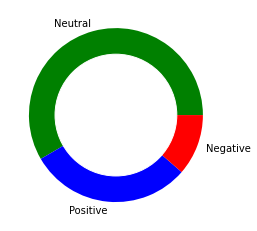

In [156]:
total=wildfire.loc[:,"Analysis"].value_counts(dropna=False)
percentage=round(wildfire.loc[:,"Analysis"].value_counts(dropna=False,normalize=True)*100,2)
pichart = pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
names= pichart.index
size=pichart["Percentage"]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### Moving Average

In [218]:
wildfire = wildfire.sort_values(by='date', ascending=True)
wildfire
wildfire['MA Polarity'] = wildfire.polarity.rolling(10, min_periods=5).mean()

In [219]:
wildfire

,Unnamed: 0.1,Unnamed: 0,tweets,date,rt,fav,clean_tweets,sep_tweets,Subjectivity,Polarity,Analysis,polarity,subjectivity,MA Polarity
15015,14999,14999,@SadiqMaunde Wildfire,2022-08-07 08:10:00,0,0.0,wildfire,[wildfire],0.000000,0.000000,Neutral,0.000000,0.000000,NaN
15014,14998,14998,Want your life reduced to this bag due to wild...,2022-08-07 08:12:00,6,6.0,want life reduc bag due wildfire flood would r...,"[want, life, reduc, bag, due, wildfire, flood,...",0.375000,-0.125000,Negative,-0.125000,0.375000,NaN
15013,14997,14997,Now playing on WGMU: 1999 WILDFIRE (CLEAN) by ...,2022-08-07 08:28:00,0,0.0,ow play wgmu wildfire clean brockhampton best ...,"[ow, play, wgmu, wildfire, clean, brockhampton...",0.500000,0.683333,Positive,0.683333,0.500000,NaN
15012,14996,14996,devastating in particular for the Karuk and Yu...,2022-08-07 08:32:00,2,1.0,devast particular karuk yurok tribe tri protec...,"[devast, particular, karuk, yurok, tribe, tri,...",0.333333,0.166667,Positive,0.166667,0.333333,NaN
15011,14995,14995,@Joe71545644 They are able to go out immediate...,2022-08-07 08:33:00,0,0.0,"abl go immedi say media ""russia target civilia...","[abl, go, immedi, say, medium, russia, target,...",0.000000,0.000000,Neutral,0.000000,0.000000,0.145000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,4,4,Pretty serious #wildfire at Newgale right now ...,2022-08-14 14:09:00,1,1.0,pretti seriou wildfire newgal right pembrokesh...,"[pretti, seriou, wildfire, newgal, right, pemb...",0.535714,0.285714,Positive,0.285714,0.535714,0.022321
3,3,3,Europe's blistering summer may not be over yet...,2022-08-14 14:10:00,0,0.0,europ blister summer may yet alreadi break rec...,"[europ, blister, summer, may, yet, alreadi, br...",0.000000,0.000000,Neutral,0.000000,0.000000,0.022321
2,2,2,@Ebuka243 just like a wildfire🦍,2022-08-14 14:10:00,0,0.0,like wildfire,"[like, wildfire]",0.000000,0.000000,Neutral,0.000000,0.000000,0.022321
1,1,1,*Flashback*\n\nAugust 2017... wildfire Smoke b...,2022-08-14 14:10:00,0,0.0,flashback august wildfire smoke block sun midd...,"[flashback, august, wildfire, smoke, block, su...",0.000000,0.000000,Neutral,0.000000,0.000000,0.022321


In [222]:
wildfire["date"] = pd.to_datetime(wildfire["date"], format = "%d/%m/%Y %H:%M") #convert it to the date
wildfire["date"]

15015   2022-08-07 08:10:00
15014   2022-08-07 08:12:00
15013   2022-08-07 08:28:00
15012   2022-08-07 08:32:00
15011   2022-08-07 08:33:00
                ...        
4       2022-08-14 14:09:00
3       2022-08-14 14:10:00
2       2022-08-14 14:10:00
1       2022-08-14 14:10:00
0       2022-08-14 14:12:00
Name: date, Length: 14955, dtype: datetime64[ns]

Text(0.5, 1.0, 'Wildfires 10 Tweet Moving Average')

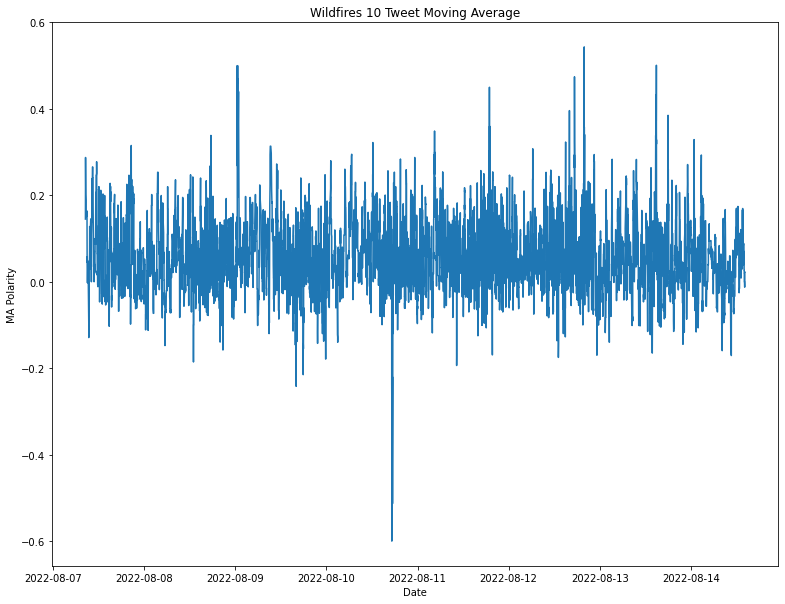

In [223]:
# Use similar to plt.figure() except use tuple unpacking to grab fig and axes
fig, axes = plt.subplots(figsize=(13,10))

# axes object to add stuff to plot
axes.plot(wildfire['date'], wildfire['MA Polarity'])
axes.set_xlabel('Date')
axes.set_ylabel('MA Polarity')
axes.set_title('Wildfires 10 Tweet Moving Average')